**Objective**
Based on customer spending patterns & transaction frequency need to offer credit cards - different products (Platinum/Gold/Silver).I am using
PURCHASES	How much customer spends
TRANSACTION_FREQUENCY	How often customer spends
INCOME	Customer's income
Please note that CREDIT_LIMIT (we can treat as proxy for income, because banks set credit limits based on income) CREDIT_LIMIT ≈ INCOME estimate
I am using using kaggle set for credit card classification.

In [1]:
# Step 1: Install and setup Kaggle API
!pip install kaggle


In [3]:
# Step 3: Setup Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Step 4: Download Dataset
!kaggle datasets download -d arjunbhasin2013/ccdata

# Unzip
!unzip ccdata.zip

Dataset URL: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
License(s): CC0-1.0
ccdata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ccdata.zip
replace CC GENERAL.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: CC GENERAL.csv          


In [10]:
!ls

 ccdata.zip  'CC GENERAL.csv'   sample_data


In [13]:
# Step 5: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [12]:
# Step 6: Load Data
data = pd.read_csv('CC GENERAL.csv')
print("Data shape:", data.shape)
data.head()


Data shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [14]:
# Step 7: Feature Selection X has 3 important dimensions:Amount (PURCHASES),
Frequency (PURCHASES_FREQUENCY),Income (CREDIT_LIMIT).
features = ['PURCHASES', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT']
X = data[features]

In [15]:
# Step 8: Handle Missing Values
X = X.fillna(0)


In [16]:
# Step 9: Standardize Features -- Standardize all features in X (your input data) KMeans needs scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

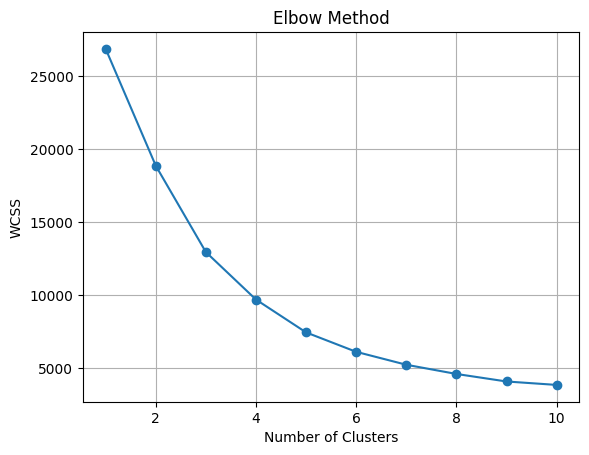

In [17]:
# Step 10: Find Optimal K using Elbow Method -- KMeans Clustering requires you to specify the number of clusters k before training.--But — How to choose the best k? 🤔
# Here Elbow Method comes in!
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [18]:
# Step 11: Apply K-Means Clustering --each customer is assigned a Cluster (0, 1, 2)
optimal_k = 3  # You can adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)
data['Cluster'] = clusters

In [24]:
# Step 12: Analyze Clusters
#Cluster with high spending, high payments → 💳 Platinum Card Cluster with medium spending → 💳 Gold Card Cluster with low spending → 💳 Silver Card
print("\nCluster Averages:")
print(data.groupby('Cluster')[features].mean())


Cluster Averages:
           PURCHASES  PURCHASES_FREQUENCY  CREDIT_LIMIT
Cluster                                                
0        3915.013621             0.808830  10904.492883
1        1051.000325             0.846702   3277.929336
2         206.805743             0.118282   3813.789738


In [21]:
# Step 13: Map Cluster to Card Type

def map_card_type(cluster):
    if cluster == 0:
        return 'Gold'
    elif cluster == 1:
        return 'Platinum'
    else:
        return 'Silver'

data['Card_Type'] = data['Cluster'].apply(map_card_type)

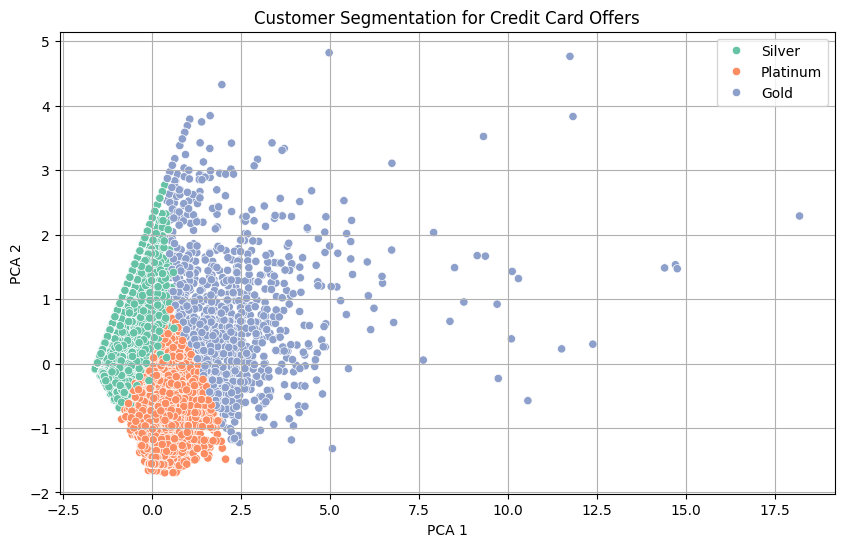

In [22]:
# Step 14: Visualize Clusters--We will see clear clusters of Platinum, Gold, and Silver customers
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data['Card_Type'], palette='Set2')
plt.title('Customer Segmentation for Credit Card Offers')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Step 15: View Final Customer Data
print("\nSample of Final Data:")
data[['PURCHASES', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'Cluster', 'Card_Type']].head()


Sample of Final Data:


,PURCHASES,PURCHASES_FREQUENCY,CREDIT_LIMIT,Cluster,Card_Type
0,95.40,0.166667,1000.0,2,Silver
1,0.00,0.000000,7000.0,2,Silver
2,773.17,1.000000,7500.0,1,Platinum
3,1499.00,0.083333,7500.0,2,Silver
4,16.00,0.083333,1200.0,2,Silver


from matplotlib import pyplot as plt
_df_0['PURCHASES'].plot(kind='hist', bins=20, title='PURCHASES')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['PURCHASES_FREQUENCY'].plot(kind='hist', bins=20, title='PURCHASES_FREQUENCY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['CREDIT_LIMIT'].plot(kind='hist', bins=20, title='CREDIT_LIMIT')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Cluster'].plot(kind='hist', bins=20, title='Cluster')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Card_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='PURCHASES', y='PURCHASES_FREQUENCY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='PURCHASES_FREQUENCY', y='CREDIT_LIMIT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='CREDIT_LIMIT', y='Cluster', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['PURCHASES'].plot(kind='line', figsize=(8, 4), title='PURCHASES')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['PURCHASES_FREQUENCY'].plot(kind='line', figsize=(8, 4), title='PURCHASES_FREQUENCY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['CREDIT_LIMIT'].plot(kind='line', figsize=(8, 4), title='CREDIT_LIMIT')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Cluster'].plot(kind='line', figsize=(8, 4), title='Cluster')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='PURCHASES', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='PURCHASES_FREQUENCY', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='CREDIT_LIMIT', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Cluster', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['PURCHASES'].plot(kind='hist', bins=20, title='PURCHASES')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['PURCHASES_FREQUENCY'].plot(kind='hist', bins=20, title='PURCHASES_FREQUENCY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['CREDIT_LIMIT'].plot(kind='hist', bins=20, title='CREDIT_LIMIT')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('Card_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='index', y='PURCHASES', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='PURCHASES', y='PURCHASES_FREQUENCY', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='PURCHASES_FREQUENCY', y='CREDIT_LIMIT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='CREDIT_LIMIT', y='Cluster', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['PURCHASES']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Card_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Card_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('PURCHASES')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['PURCHASES_FREQUENCY']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Card_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Card_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('PURCHASES_FREQUENCY')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['CREDIT_LIMIT']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Card_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Card_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('CREDIT_LIMIT')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Cluster']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Card_Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Card_Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Cluster')

from matplotlib import pyplot as plt
_df_29['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['PURCHASES'].plot(kind='line', figsize=(8, 4), title='PURCHASES')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['PURCHASES_FREQUENCY'].plot(kind='line', figsize=(8, 4), title='PURCHASES_FREQUENCY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['CREDIT_LIMIT'].plot(kind='line', figsize=(8, 4), title='CREDIT_LIMIT')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='index', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='PURCHASES', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='PURCHASES_FREQUENCY', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['Card_Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='CREDIT_LIMIT', y='Card_Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Summary Nowadays Bank analyzes customer spending patterns & Offers different products (Platinum/Gold/Silver).The Objective is to increase profits by targeted marketing.They want to reduce risk by grouping similar customers!